In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 123 
TEST_PCT = 0.3
LABELS = ["Normal","Anomaly"]

In [2]:
dfcpu = pd.read_csv('../data/processed/cpu4.csv')

In [3]:
dfcpu

,timestamp,value,label,datetime,date,time,day,hour,minute
0,1469376000,0.847300,0,2016-07-24 16:00:00,2016-07-24,16:00:00,Sunday,16,0
1,1469376300,-0.036137,0,2016-07-24 16:05:00,2016-07-24,16:05:00,Sunday,16,5
2,1469376600,0.074292,0,2016-07-24 16:10:00,2016-07-24,16:10:00,Sunday,16,10
3,1469376900,0.074292,0,2016-07-24 16:15:00,2016-07-24,16:15:00,Sunday,16,15
4,1469377200,-0.036137,0,2016-07-24 16:20:00,2016-07-24,16:20:00,Sunday,16,20
...,...,...,...,...,...,...,...,...,...
17563,1474644900,0.074292,0,2016-09-23 15:35:00,2016-09-23,15:35:00,Friday,15,35
17564,1474645200,0.295152,0,2016-09-23 15:40:00,2016-09-23,15:40:00,Friday,15,40
17565,1474645500,0.074292,0,2016-09-23 15:45:00,2016-09-23,15:45:00,Friday,15,45
17566,1474645800,-0.146567,0,2016-09-23 15:50:00,2016-09-23,15:50:00,Friday,15,50


In [4]:
print(dfcpu.label.value_counts(), "\n","--------------------------")
print("in percentage", "\n", "--------------------------")
print(dfcpu.label.value_counts(normalize=True))

0    17359
1      209
Name: label, dtype: int64 
 --------------------------
in percentage 
 --------------------------
0    0.988103
1    0.011897
Name: label, dtype: float64


In [25]:
raw_data = dfcpu[['timestamp','value','label']].copy()
raw_data

,timestamp,value,label
0,1469376000,0.847300,0
1,1469376300,-0.036137,0
2,1469376600,0.074292,0
3,1469376900,0.074292,0
4,1469377200,-0.036137,0
...,...,...,...
17563,1474644900,0.074292,0
17564,1474645200,0.295152,0
17565,1474645500,0.074292,0
17566,1474645800,-0.146567,0


In [26]:
# sc=StandardScaler()

scaler = MinMaxScaler(feature_range=(0, 1))

raw_data['timestamp'] = scaler.fit_transform(raw_data['timestamp'].values.reshape(-1, 1))
raw_data['value'] = scaler.fit_transform(raw_data['value'].values.reshape(-1, 1))

raw_data.head()

,timestamp,value,label
0,0.000000,0.450980,0
1,0.000057,0.294118,0
2,0.000114,0.313725,0
3,0.000171,0.313725,0
4,0.000228,0.294118,0


In [28]:
raw_data2 = dfcpu[['timestamp','value','label']].copy()
sc=StandardScaler()

raw_data2['timestamp'] = sc.fit_transform(raw_data2['timestamp'].values.reshape(-1, 1))
raw_data2['value'] = sc.fit_transform(raw_data2['value'].values.reshape(-1, 1))

raw_data2.head()

,timestamp,value,label
0,-1.731952,0.847300,0
1,-1.731755,-0.036137,0
2,-1.731558,0.074292,0
3,-1.731361,0.074292,0
4,-1.731163,-0.036137,0


In [7]:
raw_data = raw_data.values
labels = raw_data[:,-1]
labels

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
data = raw_data[:, 0:-1]
data

array([[0.00000000e+00, 4.50980392e-01],
       [5.69249161e-05, 2.94117647e-01],
       [1.13849832e-04, 3.13725490e-01],
       ...,
       [9.99886150e-01, 3.13725490e-01],
       [9.99943075e-01, 2.74509804e-01],
       [1.00000000e+00, 2.94117647e-01]])

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=RANDOM_SEED
)

In [11]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
anomaly_train_data = train_data[train_labels]
anomaly_test_data = test_data[test_labels]
print(" No. of records in Anomaly Train Data=",len(anomaly_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Anomaly Test Data=",len(anomaly_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Anomaly Train Data= 156
 No. of records in Normal Train data= 13898
 No. of records in Anomaly Test Data= 53
 No. of records in Normal Test data= 3461


In [12]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7

In [13]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",                                activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 14)                42        
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [14]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [15]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [16]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
204/218 [===========================>..] - ETA: 0s - loss: 0.0758 - accuracy: 0.7262
Epoch 1: val_loss improved from inf to 0.01356, saving model to autoencoder_fraud.h5
218/218 [==============================] - 3s 7ms/step - loss: 0.0725 - accuracy: 0.7330 - val_loss: 0.0136 - val_accuracy: 0.8904
Epoch 2/50
209/218 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.8837
Epoch 2: val_loss improved from 0.01356 to 0.00519, saving model to autoencoder_fraud.h5
218/218 [==============================] - 1s 5ms/step - loss: 0.0148 - accuracy: 0.8841 - val_loss: 0.0052 - val_accuracy: 0.9203
Epoch 3/50
211/218 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9084
Epoch 3: val_loss improved from 0.00519 to 0.00402, saving model to autoencoder_fraud.h5
218/218 [==============================] - 1s 5ms/step - loss: 0.0102 - accuracy: 0.9088 - val_loss: 0.0040 - val_accuracy: 0.9263
Epoch 4/50
205/218 [===========================>..] - ET

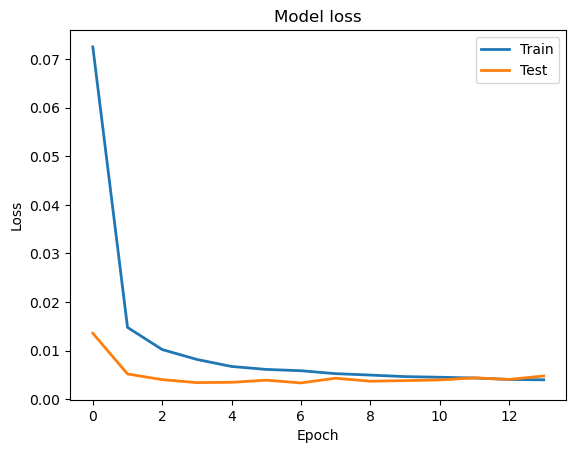

In [17]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [18]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

110/110 [==============================] - 1s 3ms/step


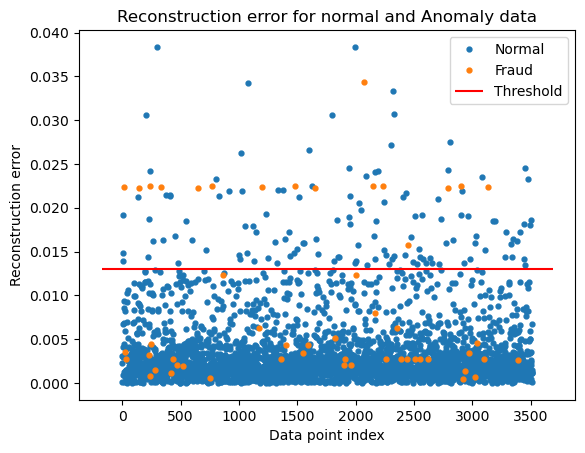

In [21]:
threshold_fixed = 0.013
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and Anomaly data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

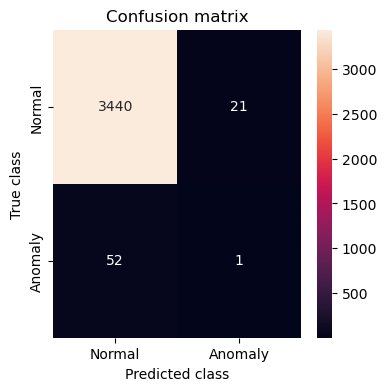

 Accuracy:  0.979225953329539
 Recall:  0.018867924528301886
 Precision:  0.045454545454545456


In [22]:
threshold_fixed =0.023
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))